In [1]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt
from Code import ULA
from Code import Algo1
from Code import ZVnbrosse

### Gaussian mixture 

## $\pi (x) = \frac{1}{2(2\pi)^{d/2}} \left( e ^{\frac{-| x-a|^2}{2}}  + e ^{\frac{-| x+a|^2}{2}} \right), \quad x \in\mathbb R^d$

$U(x) = \frac{1}{2} \|x - a\|_2^2 - \text{log}(1 + e^{-2x^\top a})$

$\nabla U(x) = x-a +2a(1 + e^{2 x^\top a})^{-1}$

$ m = 1 - \|a \|_2^2 \quad $ (strongly convex function)

$M = 1 \quad$  (Lipschitz continuous gradient)

$a = (\frac{1}{\sqrt{2d}}, \dots, \frac{1}{\sqrt{2d}})$

## Setup

In [5]:
dim = 8
h = 0.1
n = 1000
N_train = 50
N_test = 50
n_tilde = 50
deg = 1
def f_grad(x):
    a = np.ones(dim) / 8
    return x - a 

def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

### Generate sample and plot

In [6]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=100000,f_grad=f_grad)

expectation =  0.9479575579086128


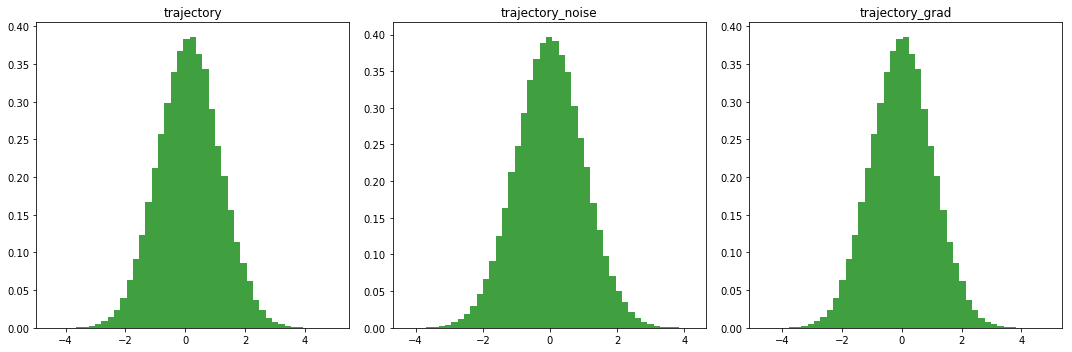

In [7]:
print ('expectation = ', local_weighted_estimator(X))
ULA.plot_distr(X,Z,G,0)

### Generate train ant test trajectories

In [8]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad)
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

### Algorithm 1 

In [9]:
Betas, degrees = Algo1.G_pml_fit_meansum(XX,max_deg = deg)

100%|██████████| 1000/1000 [00:04<00:00, 206.84it/s]


In [10]:
k_comb = np.zeros((dim,dim), dtype=np.int16)
for i in range(dim):
    k_comb[i,i] = 1

# k_comb = np.array([[1,0], [0,1], [1,1], [2,0], [0,2]], dtype=np.int16)

### Check and time

In [11]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], h, degrees,Betas, n_tilde)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = 1.2272299916624019
            (k = [1 0 0 0 0 0 0 0]) = 1.238738864659978 [Time:41.847257797002385]
            (k = [0 1 0 0 0 0 0 0]) = 1.3177103956482294 [Time:84.21489848800411]
            (k = [0 0 1 0 0 0 0 0]) = 1.0975873416588138 [Time:126.39794491499924]
            (k = [0 0 0 1 0 0 0 0]) = 1.1128058150170936 [Time:168.26948809600435]
            (k = [0 0 0 0 1 0 0 0]) = 1.1078289011795566 [Time:209.90946464000444]
            (k = [0 0 0 0 0 1 0 0]) = 0.9131296360796564 [Time:251.5825928980048]
            (k = [0 0 0 0 0 0 1 0]) = 1.0273850307188848 [Time:293.1780042130049]
            (k = [0 0 0 0 0 0 0 1]) = 1.043931322826207 [Time:334.801383955004]


## Check results on test trajectories

In [12]:
P_test = estimator(XX_test)

M_test = np.empty((len(k_comb),P_test.shape[0]))
for i in range(len(k_comb)):
    M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, h, degrees,Betas, n_tilde, n_jobs=8)

100%|██████████| 50/50 [00:00<00:00, 15360.38it/s]


In [13]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVnbrosse.ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_cv_2 = np.array(res_cv_2).reshape(-1)

/home/yerlan.turashev/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning:

divide by zero encountered in true_divide

/home/yerlan.turashev/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning:

invalid value encountered in true_divide



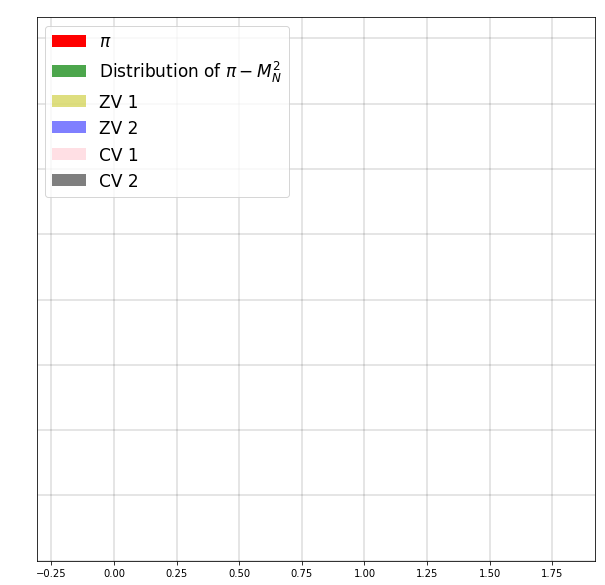

In [19]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.7, label="Distribution of $\pi - M^2_N$")

plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.5, label="ZV 1")
plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.5, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.5, label="CV 1")
plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.5, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
# plt.xlim(-0.65, 0.65)
plt.show()

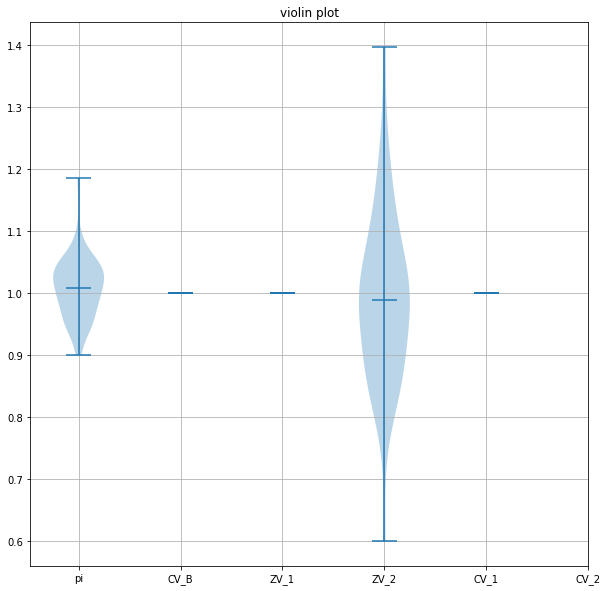

In [30]:
# all_data = [P_test]
all_data = []
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,7), ('pi', 'CV_B', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()

In [26]:
res_cv_2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i+1].sum(axis = 0)).var(ddof = 1))
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

          Variance of Pi =  0.16765056657999874
Variance of new estimator = 0.14106235830509428
Variance of new estimator = 0.14614325895556243
Variance of new estimator = 0.12126559663221526
Variance of new estimator = 0.09824354492643957
Variance of new estimator = 0.06675737494294492
Variance of new estimator = 0.03613857845390991
Variance of new estimator = 0.023817025719912448
Variance of new estimator = 0.0024536131388902876
        Variance of CV 1 =  0.018652074170195806
        Variance of CV 2 =  1.763365735203856e-31
        Variance of ZV 1 =  2.3142603086840909e-32
        Variance of ZV 2 =  2.7595038680722257e-31


In [27]:
print ('VRF CVB = ',P_test.var(ddof = 1)/ (P_test - M_test.sum(axis = 0)).var(ddof=1))
print ('VRF CV1 = ',P_test.var(ddof = 1)/res_cv_1.var(ddof = 1))
print ('VRF CV2 = ',P_test.var(ddof = 1)/res_cv_2.var(ddof = 1))
print ('VRF ZV1 = ',P_test.var(ddof = 1)/res_zv_1.var(ddof = 1))
print ('VRF ZV2 = ',P_test.var(ddof = 1)/res_zv_2.var(ddof = 1))

VRF CVB =  68.32803587603188
VRF CV1 =  8.988306879450864
VRF CV2 =  9.507418865696474e+29
VRF ZV1 =  7.244239809623074e+30
VRF ZV2 =  6.075387989838859e+29


In [28]:
np.save("logs/gaussian_8d_M_test_(K = {}, n_tilde={}).npy".format(deg, n_tilde), M_test)